In [1]:
import sys
import os
os.chdir("C:\\Users\\Zber\\Documents\\Dev_program\\OpenRadar")
import numpy as np
import mmwave.dsp as dsp
from mmwave.dataloader import DCA1000
from mmwave.dsp.utils import Window
from FER.utils import parseConfigFile, arange_tx
from mmwave.dsp.cfar import ca, ca_, cago_, caso_, os_
import matplotlib.pyplot as plt
# figpath = "C:/Users/Zber/Desktop/mmWave_figure"
figpath = "C:/Users/Zber/Desktop/SavedFigure"
configFileName = 'C:/Users/Zber/Desktop/mmWave Configuration/profile_3d_aop_3s.cfg'

In [2]:
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


cmap = plt.get_cmap('hot')
hot_cmap = truncate_colormap(cmap, 0.0, 0.5)

In [3]:
# num Antennas
numTxAntennas = 3
numRxAntennas = 4
# load configure parameters
config = parseConfigFile(configFileName)

# mmWave radar settings
numFrames = config['numFrames']
numADCSamples = config['numAdcSamples']
numLoopsPerFrame = config['numLoops']
numChirpsPerFrame = numTxAntennas * numLoopsPerFrame
numAngleBins = 64

# aoa related
VIRT_ELE_PAIRS = [[8, 2], [9, 3], [10, 4], [11, 5]]
VIRT_AZI_PAIRS = [[i for i in range(0, 8)]]

# azimuth
ANGLE_RES_AZI = 1
ANGLE_RANGE_AZI = 90
ANGLE_BINS_AZI = (ANGLE_RANGE_AZI * 2) // ANGLE_RES_AZI + 1
VIRT_ANT_AZI = 8

# elevation
ANGLE_RES_ELE = 1
ANGLE_RANGE_ELE = 30
ANGLE_BINS_ELE = (ANGLE_RANGE_ELE * 2) // ANGLE_RES_ELE + 1
VIRT_ANT_ELE = 2

BIN_RANG_S = 0
BIN_RANG_E = 256
BINS_PROCESSED = BIN_RANG_E - BIN_RANG_S
VIRT_ANT_AZI_INDEX = [i for i in range(0, 8)]
VIRT_ANT_ELE_INDEX = VIRT_ELE_PAIRS[2]

# data processing parameter
range_resolution, bandwidth = dsp.range_resolution(config['numAdcSamples'],
                                                    dig_out_sample_rate=config['digOutSampleRate'],
                                                    freq_slope_const=config['freqSlopeConst'])

doppler_resolution = dsp.doppler_resolution(bandwidth, start_freq_const=config['startFreq'],
                                            ramp_end_time=config['rampEndTime'],
                                            idle_time_const=config['idleTime'],
                                            num_loops_per_frame=config['numLoops'],
                                            num_tx_antennas=numTxAntennas)

print('Range Resolution: {:.2f}cm, Bandwidth: {:.2f}Ghz, Doppler Resolution: {:.2f}m/s'.format(
    range_resolution * 100, bandwidth / 1000000000, doppler_resolution))


Range Resolution: 4.22cm, Bandwidth: 3.56Ghz, Doppler Resolution: 0.43m/s


In [17]:
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/Surprise_dynamic_0_Raw_0.bin"
adc_data_path = "C:/Users/Zber/Desktop/Subjects/Multi_People/Surprise_100cm_fan_movePeople_9_Raw_0.bin"

In [18]:
# Reading in adc data
adc_data = np.fromfile(adc_data_path, dtype=np.int16)
adc_data = adc_data.reshape(numFrames, -1)
adc_data = np.apply_along_axis(DCA1000.organize_cli, 1, adc_data, num_chirps=numChirpsPerFrame,
                                num_rx=numRxAntennas, num_samples=numADCSamples)
print("Data Loaded!")

# processing range data
# window types : Bartlett, Blackman p, Hanning p and Hamming
range_data = dsp.range_processing(adc_data)
# range_data = dsp.range_processing(adc_data, window_type_1d=Window.HANNING)
range_data = arange_tx(range_data, num_tx=numTxAntennas)

Data Loaded!


(300, 32, 12, 256)


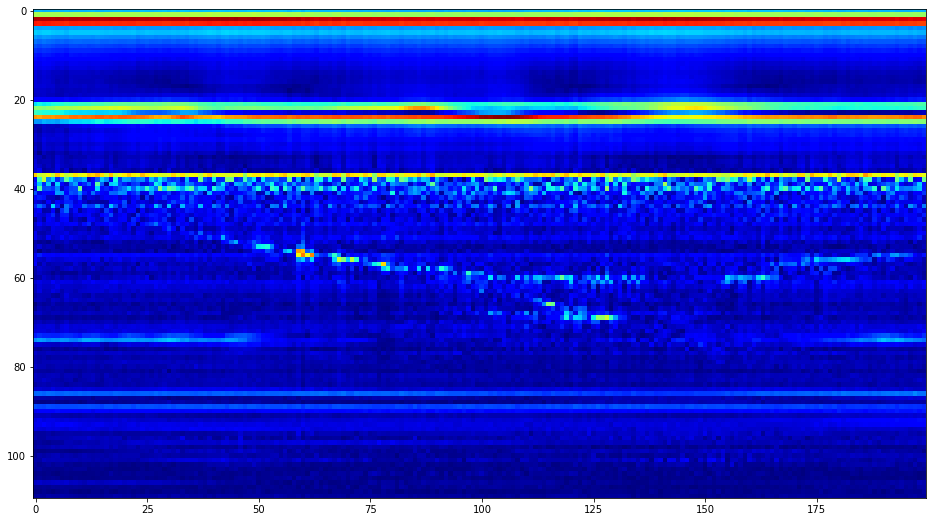

In [19]:
# range profile
print(range_data.shape)
fig5, axes5 = plt.subplots(1, 1, figsize=(16, 9))
range_plot_data = np.abs(np.mean(range_data[50:250,15,:,0:110],axis=(1)))
# range_plot_data = np.mean(range_data,axis=(1,2))
# range_plot_data = range_data[:,15,2,:50]
# axes5.imshow(np.abs(range_plot_data.T), cmap=plt.get_cmap('hot'))
axes5.imshow(np.abs(range_plot_data.T), cmap=plt.get_cmap('jet'), aspect='auto')

# range_plot_data = np.log2(range_plot_data)
# range_plot_data = np.log10(range_plot_data) * 20

In [29]:
# g_data = np.mean(range_plot_data[:100], axis=0)
rd = range_plot_data[60]
rd[0:10] = rd[95:105]
rd = rd[:100]
grad_data = np.abs(np.diff(rd))
grad_data = np.log10(grad_data) * 20

sb = 52
eb = 57

grad_data[sb:eb+1] = (grad_data[sb] + grad_data[eb])/2

[Text(0.0, 0, '0'),
 Text(23.72011343631304, 0, '1'),
 Text(47.44022687262608, 0, '2'),
 Text(71.16034030893911, 0, '3'),
 Text(94.88045374525215, 0, '4')]

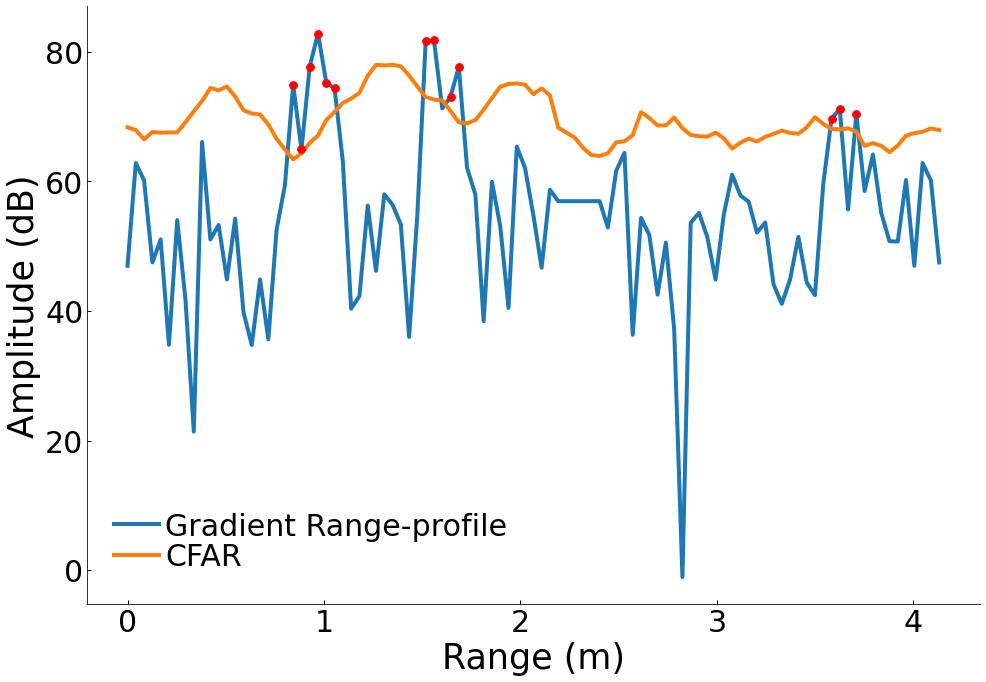

In [77]:
unit = 0.042158314406249994
fig3, axes3 = plt.subplots(1, 1, figsize=(16, 11))

threshold, noise_floor = ca_(grad_data, guard_len=5, noise_len=10, l_bound=15, mode='wrap')
# threshold, noise_floor = caso_(grad_data, guard_len=2, noise_len=5, l_bound=6, mode='wrap')

lw = 4

peaks = (grad_data > threshold)
x=np.arange(0, len(grad_data), 1)[peaks]
y=grad_data[peaks]
# axes5.plot(threshold)
axes3.plot(grad_data, linewidth=lw, label='Gradient Range-profile')
axes3.plot(threshold, linewidth=lw, label='CFAR')
# axes3.axvline(sb, c='r', lw=lw-2)
# axes3.axvline(eb, c='r', lw=lw-2)
axes3.scatter(x, y, c='red', s= 60, zorder=20)

axes3.set_xlabel("Range (m)",fontsize=35)
axes3.set_ylabel("Amplitude (dB)",fontsize=35)


axes3.spines['top'].set_visible(False)
axes3.spines['right'].set_visible(False)
axes3.yaxis.set_tick_params(labelsize=30, length=4, direction='in', width=1)
axes3.xaxis.set_tick_params(labelsize=30, length=4, direction='in', width=1)

axes3.legend(loc="upper left", prop={'size': 30, }, ncol=1, bbox_to_anchor=(0.0, 0.2), fancybox=True,
               framealpha=0.0, labelspacing=0.05, handletextpad=0.2, columnspacing=0.5, handlelength=1.5)

y_txt = np.arange(0,5, step=1)
y_pos = y_txt/unit
axes3.set_xticks(y_pos)
axes3.set_xticklabels(y_txt,fontsize=30)
# fig3.savefig('C:/Users/Zber/Desktop/mmEmo_Exp/0.Method/m1_3.svg', format='svg', bbox_inches="tight")


In [76]:
x

array([20, 22, 23, 24, 25, 36, 37, 40, 85, 86, 88])